In [24]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm
from scipy.interpolate import interp1d
import pandas as pd
from CoolProp.CoolProp import PropsSI

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'c:\\Users\\aaeft\\Documents\\GitHub\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [12]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

## Read the Excel file of the experimental data

In [26]:
# TODO: add excel reader for updating the model input for optimization
# df = pd.read_excel("E-31-1-flooding-formatted.xlsx")
xls = pd.ExcelFile("E-31-1-flooding-formatted.xlsx")
sheet_names = xls.sheet_names
print(sheet_names)

['core', 'condition', 'brine', 'oil', 'drainage_dp', 'drainage_So', 'flooding_dp', 'flooding_R', 'flooding_effluent']


In [25]:
df = pd.read_excel("E-31-1-flooding-formatted.xlsx", sheet_name=None)

In [29]:
core_dics = df['core'].set_index('parameter')['value'].to_dict()
oil_dict = df['oil'].set_index('property')['value'].to_dict()
cond_dict = df['condition'].set_index('parameter')['value'].to_dict()

In [28]:
df['condition']

,parameter,value,unit
0,temperature,70.0,degC
1,back_pressure,200.0,bar
2,injection_rate,0.1,cm^3/min


In [32]:
BC.injection_rate_ml_min = cond_dict['injection_rate'] # ml/min
BC.production_pressure = cond_dict['back_pressure']*1e5 # Pa
T = cond_dict['temperature'] + 273.15 # K

core_plug.core_length = core_dics['L']/100 # m
core_plug.core_diameter = core_dics['D']/100 # m
core_plug.porosity = core_dics['porosity']
core_plug.permeability = core_dics['perm_water']*1e-15 # m2
core_plug.pore_volume = core_dics['pore_volume']/1e6 # m3
core_plug.cross_sectional_area = core_plug.core_diameter**2*np.pi/4 # m2

fluids.oil_density = oil_dict['density'] # kg/m3
fluids.oil_viscosity = oil_dict['viscosity'] # Pa.s
fluids.water_density = PropsSI('D', 'T', T, 'P', BC.production_pressure, 'water') # kg/m3
fluids.water_viscosity = PropsSI('V', 'T', T, 'P', BC.production_pressure, 'water') # Pa.s

IC.sw = 1 - core_dics['Soi']
IC.p = BC.production_pressure
IC.T = T

{'L': 6.08,
 'D': 3.794,
 'porosity': 0.2745,
 'perm_air': 0.91,
 'perm_water': 1.07,
 'pore_volume': 18.86819962975388,
 'Soi': 0.8029}

In [56]:
# df_sw = df['flooding_R'][df['flooding_R']['brine']=='SW']
df_sw = df['flooding_R']
df_sw = df_sw[df_sw['injecting brine']=='SW']
PV_R = df_sw['PV'].to_numpy()
R = df_sw['RF'].to_numpy()
# cm3/s x t = cm3 = pv x pore_volume -> t = pv x pore_volume[cm3] / cm3/s
t_R = PV_R * core_plug.pore_volume*1e6 / (BC.injection_rate_ml_min/60)
df_dp = df['flooding_dp']
df_dp = df_dp[df_dp['injecting brine']=='SW']
PV_dp = df_dp['PV'].to_numpy()
dp = df_dp['DeltaP'].to_numpy()
dp_filtered = interp1d(PV_dp, dp, kind='linear', fill_value='extrapolate')(PV_R)

numerical_params.simulation_time = t_R[-1]*1.1

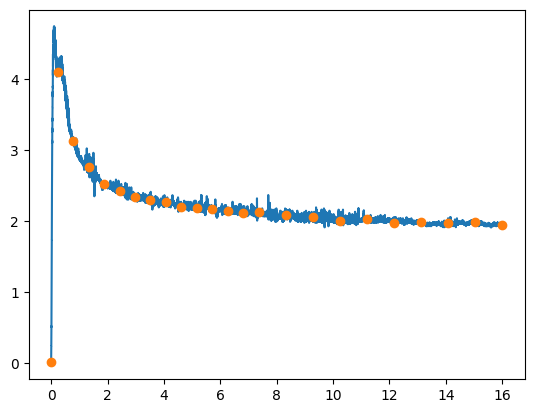

In [57]:
plt.plot(PV_dp, dp)
plt.plot(PV_R, dp_filtered, 'o')

In [58]:
cf_1d = cf.CoreFlooding1D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=30
)

cf2d = cf.CoreFlooding2D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=20, Nr = 5
)

xt_shock, sw_shock, xt_prf, sw_prf, t_ana, p_inj_ana, R_oil_ana = ff.frac_flow_wf(
    fluids, rel_perm_ww, core_plug, IC, ut=cf_1d.u_inj, sw_inj=1.0, pv_inj=3.0)

c:\Users\aaeft\venvs\myfvm\Lib\site-packages\pyfvtool\cell.py:97: RuntimeWarning: invalid value encountered in divide
  return CellVariable(self.domain, self.value/other.value)


In [59]:
t_data, R_data, dp_data = t_R, R, dp_filtered*1e5 #cf_1d.simulate_no_pc()


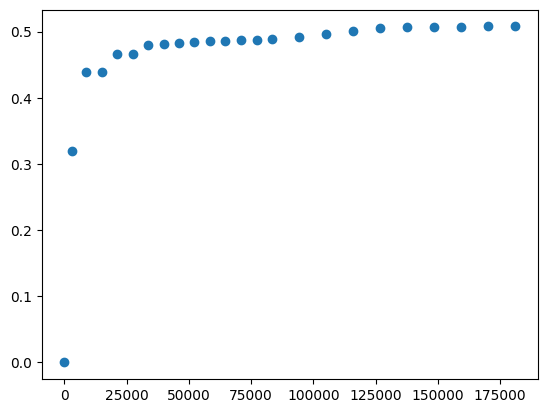

In [60]:
plt.plot(t_data, R_data, 'o')
# cf_1d.numerical_params.simulation_time = 130000.0

## Fittin model to core flooding data

In [82]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import minimize, Parameters, Model
def residual(params, t, R):
    cf_1d.rel_perm.kro0 = params['kro0']
    cf_1d.rel_perm.krw0 = params['krw0']
    cf_1d.rel_perm.nw = params['nw']
    cf_1d.rel_perm.no = params['no']
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num)(t)
    return (R_calc - R)

def my_model(t, krw0, kro0, nw, no, swc, sor):
    cf_1d.rel_perm.kro0 = kro0
    cf_1d.rel_perm.krw0 = krw0
    cf_1d.rel_perm.nw = nw
    cf_1d.rel_perm.no = no
    cf_1d.rel_perm.swc = swc
    cf_1d.rel_perm.sor = sor
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num, fill_value='extrapolate')(t)
    dp_calc = interp1d(t_num, dp_num, fill_value='extrapolate')(t)
    return R_calc, dp_calc

model = Model(my_model)

params = Parameters()
params.add('kro0', value=0.5, min=0.1, max=1.0)
params.add('krw0', value=0.2, min=0.05, max=0.6)
params.add('no', value=2.0, min=1.0, max=3.0)
params.add('nw', value=2.0, min=1.0, max=3.0)
params.add('swc', value=0.2, min=0.01, max=0.25)
params.add('sor', value=0.45, min=0.01, max=0.5)

W_R = np.ones_like(t_data)
W_dp = 1e-5*np.ones_like(t_data)
result = model.fit((R_data, dp_data), params, t=t_data, verbose=True, weights=(W_R, W_dp))

# out = minimize(residual, params, args=(t_data, R_data))

In [83]:
print(result.fit_report())
print("Optimized Parameters:")
print(result.params)

[[Model]]
    Model(my_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 48
    # variables        = 6
    chi-square         = 13.1847060
    reduced chi-square = 0.31392157
    Akaike info crit   = -50.0228873
    Bayesian info crit = -38.7956813
    R-squared          = 1.00000000
[[Variables]]
    kro0:  0.50000025 +/- 3.6809e-05 (0.01%) (init = 0.5)
    krw0:  0.19999998 +/- 5.0642e-05 (0.03%) (init = 0.2)
    no:    2.00000514 +/- 2.8403e-09 (0.00%) (init = 2)
    nw:    1.99999794 +/- 1.1619e-09 (0.00%) (init = 2)
    swc:   0.19999986 +/- 6.3243e-06 (0.00%) (init = 0.2)
    sor:   0.44999967 +/- 5.4899e-05 (0.01%) (init = 0.45)
[[Correlations]] (unreported correlations are < 0.100)
    C(krw0, sor)  = -0.9623
    C(kro0, no)   = +0.9281
    C(kro0, krw0) = -0.4807
    C(krw0, no)   = -0.4384
    C(kro0, sor)  = +0.4160
    C(no, sor)    = +0.4074
    C(no, swc)    = -0.2111
    C(nw, sor)    = -0.2092
    C(krw0, nw)

In [84]:
R_fit, dp_fit = result.eval()


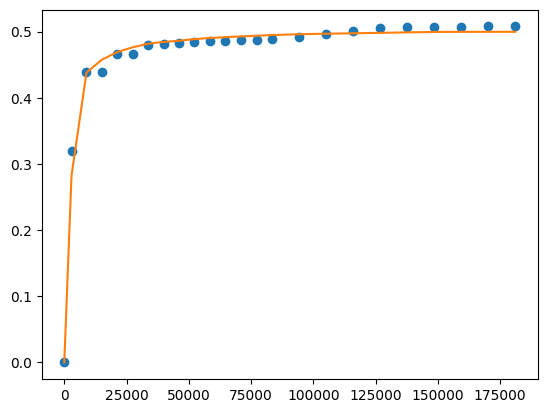

In [85]:
plt.plot(t_data, R_data, 'o')
plt.plot(t_data, R_fit, '-')

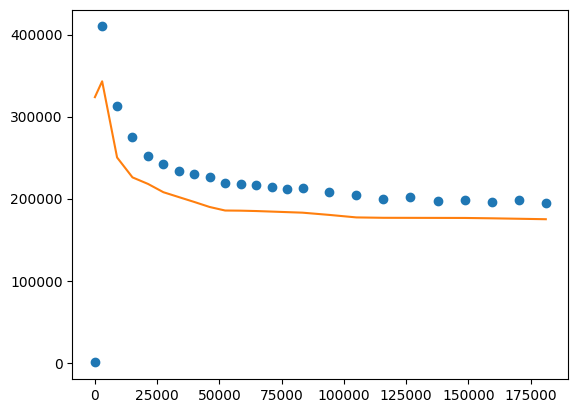

In [86]:
plt.plot(t_data, dp_data, 'o')
plt.plot(t_data, dp_fit, '-')